# The Metropolis Algorithm
## Packages and Config

In [223]:
include("Metropolis.jl");
using StatsPlots, LaTeXStrings, StatsBase, LinearAlgebra, Distributions
figpath = "../fig/"
Plots.default(lw=3, ms=5, legend=false, fontfamily="Computer Modern",
    titlefontsize=18, tickfontsize=10, labelfontsize=14, legendfontsize=10)

## Distribution

In [275]:
series, seriesaccept = Metropolis.metropolis_uniform(x -> ℯ^(-x^2/2), 3, 100000000)

([0.0, 0.5305916598505918, 0.5305916598505918, 0.5305916598505918, 0.1281611393071982, 0.2702110606127053, 0.2702110606127053, -0.22867058038005528, -0.22867058038005528, -0.22867058038005528  …  1.0079925629454434, 1.0079925629454434, 1.0079925629454434, 1.8894230763587703, 1.8894230763587703, -0.38255866697864294, -0.38255866697864294, -0.38255866697864294, -0.7081664925769924, 1.1687001753072583], 0.49285279492852796)

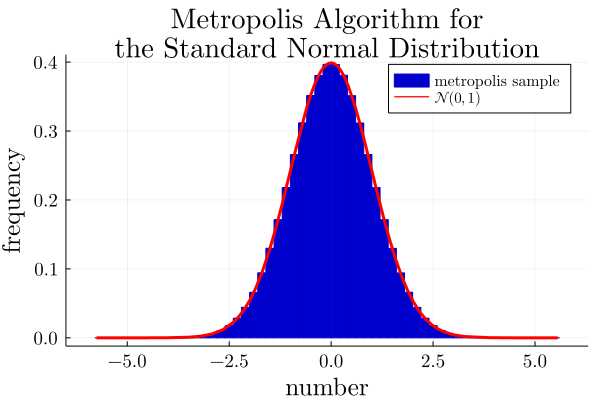

In [281]:
hist = normalize(fit(Histogram, series, nbins=60), mode=:pdf)

p = plot(hist, lw=:auto, color=:mediumblue, lc=:match,
    legend=true, label="metropolis sample",
    xlabel="number", ylabel="frequency",
    title="Metropolis Algorithm for\nthe Standard Normal Distribution",
    legendfontsize=10, labelfontsize=16, tickfontsize=12)
plot!(p, Normal(0, 1), minimum(series), maximum(series), color=:red, label=L"\mathcal{N}(0, 1)")

savefig(p, figpath * "metropolis-hist.pdf")
display(p)

## Acceptance Rate

In [111]:
stepsizes = collect(range(0.5, 15.9, length=1001))
acceptance = Float64[]

for s in stepsizes
    push!(acceptance, Metropolis.metropolis_uniform(x -> ℯ^(-x^2/2), s, 10000000)[2])
end

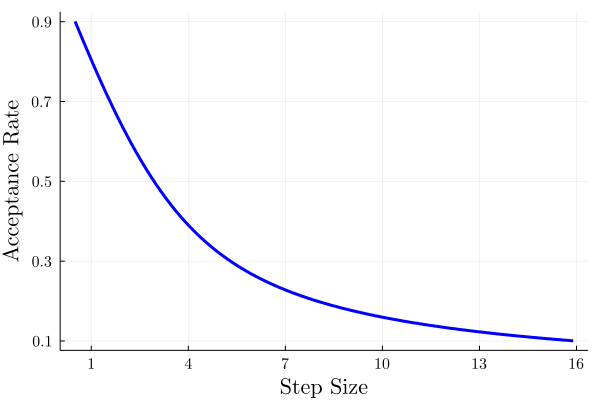

In [134]:
p = plot(stepsizes, acceptance, ylabel="Acceptance Rate", xlabel="Step Size", color=:blue,
    xticks=range(1, 16, step=3), yticks=range(0.1, 0.9, step=0.2))
savefig(p, figpath * "metropolis-acceptance.pdf")
display(p)

In [137]:
stepindex = [argmin(abs.(acceptance .- target)) for target in 0.1:0.1:0.9]
targetstep, targetaccept = stepsizes[stepindex], acceptance[stepindex]

([15.8846, 7.969, 5.3048, 3.888, 2.9486, 2.2094, 1.578, 1.0236, 0.5], [0.100362510036251, 0.199964019996402, 0.300004830000483, 0.400269840026984, 0.499095749909575, 0.599160259916026, 0.700730070073007, 0.800227380022738, 0.900778490077849])

## Autocorrelation

In [162]:
accept = Float64[]
correlation = []
for step in targetstep
    metro = Metropolis.metropolis_uniform(x -> ℯ^(-x^2/2), step, 100000000)
    push!(correlation, autocor(metro[1]))
    push!(accept, metro[2])
end

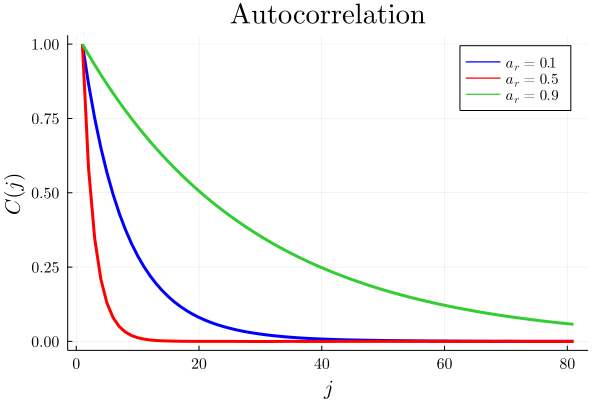

In [230]:
p = plot(correlation[[1, 5, 9]], palette=[:blue, :red, :limegreen], legend=true,
    labels = [L"a_r = 0.1" L"a_r = 0.5" L"a_r = 0.9"], title="Autocorrelation",
    xlabel=L"j", ylabel=L"C(j)")

savefig(p, figpath * "metropolis-autocor.pdf")
display(p)

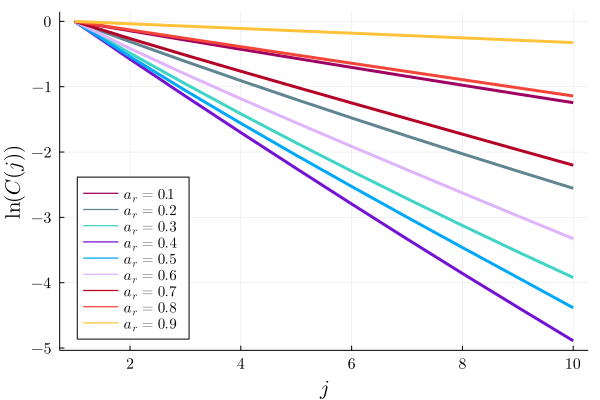

In [255]:
# cutoff correlation at 10 to avoid getting within floating-point error
correlationlog = [log.(cor[1:10]) for cor in correlation]

p = plot(correlationlog, palette=palette(:mk_12, 9),
    labels = reshape([L"a_r = %$i" for i in 0.1:0.1:0.9], (1, 9)), legend=:bottomleft,
    xlabel=L"j", ylabel=L"\mathrm{ln}(C(j))")

savefig(p, figpath * "metropolis-autocor-log.pdf")
display(p)

### Correlation Length

In [262]:
ξs = Float64[]
errors = Float64[]

x = collect(1:10)
for y in correlationlog
    ξ⁻¹, constant = hcat(x, ones(10)) \ y
    ξ = -1 / ξ⁻¹
    push!(ξs, ξ)

    errorξ⁻¹ = √(sum(t->t^2, y - ξ⁻¹ * x .- constant) / (8 * sum(t->t^2, x .- mean(x))))
    errorξ = errorξ⁻¹ / ξ⁻¹^2
    push!(errors, errorξ)
end

display(ξs)
display(errors)

9-element Vector{Float64}:
  7.2330623651526045
  3.528560536280366
  2.2997210200402183
  1.8417291953753807
  2.064174476667579
  2.723170924337147
  4.105597932152521
  7.892050181570413
 27.76088724916063

9-element Vector{Float64}:
 0.0306563291005245
 0.033341394531751195
 0.02734442089141961
 0.011961028685221427
 0.018802429534747367
 0.02427488988705136
 0.021385558650095827
 0.019272162622102136
 0.012381515425541617

In [274]:
using Latexify; latexify(round.(ξs, digits=2))

L"\begin{equation}
\left[
\begin{array}{c}
7.23 \\
3.53 \\
2.3 \\
1.84 \\
2.06 \\
2.72 \\
4.11 \\
7.89 \\
27.76 \\
\end{array}
\right]
\end{equation}
"

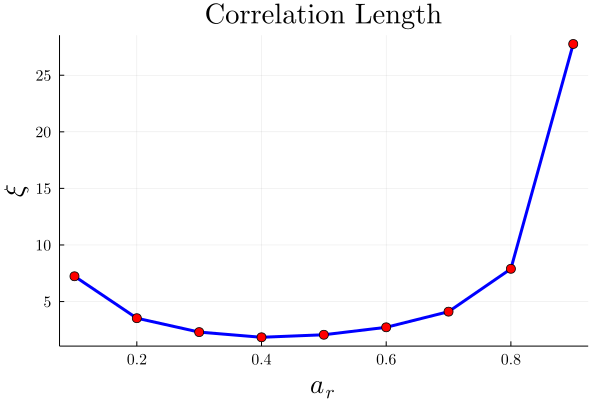

In [277]:
p = plot(0.1:0.1:0.9, ξs, marker=:circle, mc=:red, lc=:blue, labelfontsize=18,
    title="Correlation Length", xlabel=L"a_r", ylabel=L"\xi")

savefig(p, figpath * "metropolis-corlen.pdf")
display(p)